In [1]:
# Constants

LEARNING_RATE = 0.05
NUM_ITER = 2048
TARGET_CLASS = 2   # great white shark

ROTATION_DEG = 5
IMG_HEIGHT, IMG_WIDTH = 224, 224
JITTER_PX = 16
SCALE_FACTOR = 0.2

In [2]:
# Imports and Model

import torchvision.models as models
from torchvision.models import AlexNet_Weights
from torchvision.transforms import v2
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

model = models.alexnet(weights = AlexNet_Weights.IMAGENET1K_V1)
model.eval()
preprocess = AlexNet_Weights.IMAGENET1K_V1.transforms()

Iteration 10/2048: Loss: -65.30618286132812
Iteration 20/2048: Loss: -191.99147033691406
Iteration 30/2048: Loss: -287.7956848144531
Iteration 40/2048: Loss: -348.65899658203125
Iteration 50/2048: Loss: -386.95782470703125
Iteration 60/2048: Loss: -412.5152893066406
Iteration 70/2048: Loss: -430.8612060546875
Iteration 80/2048: Loss: -444.5879211425781
Iteration 90/2048: Loss: -454.9754943847656
Iteration 100/2048: Loss: -463.3827209472656
Iteration 110/2048: Loss: -470.37811279296875
Iteration 120/2048: Loss: -476.3800048828125
Iteration 130/2048: Loss: -481.3232116699219
Iteration 140/2048: Loss: -485.5318298339844
Iteration 150/2048: Loss: -489.22869873046875
Iteration 160/2048: Loss: -492.1352844238281
Iteration 170/2048: Loss: -495.003662109375
Iteration 180/2048: Loss: -497.2408447265625
Iteration 190/2048: Loss: -499.37713623046875
Iteration 200/2048: Loss: -501.3768310546875
Iteration 210/2048: Loss: -503.1907958984375
Iteration 220/2048: Loss: -504.9255676269531
Iteration 230/

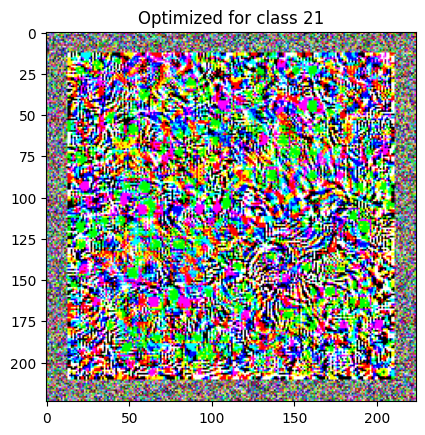

In [9]:
# Naive

image = torch.rand((1, 3, IMG_HEIGHT, IMG_WIDTH), requires_grad = True)
optimizer = torch.optim.Adam([image], lr = LEARNING_RATE)

for i in range(NUM_ITER):
  optimizer.zero_grad()
  preprocessed_image = preprocess(image)

  out = model(preprocessed_image)

  loss = -out[0, TARGET_CLASS]
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    image.data.clamp_(0, 1)

  if (i + 1) % 10 == 0:
    print(f"Iteration {i + 1}/{NUM_ITER}: Loss: {loss.item()}")

final_image = image.detach().clone().squeeze(0)
plt.imshow(TF.to_pil_image(final_image))
plt.title(f"Optimized for class {TARGET_CLASS}")
plt.show()


Iteration 10/2048: Loss: -3.8013432025909424
Iteration 20/2048: Loss: -12.370943069458008
Iteration 30/2048: Loss: -32.72753143310547
Iteration 40/2048: Loss: -43.239768981933594
Iteration 50/2048: Loss: -70.23497772216797
Iteration 60/2048: Loss: -74.50591278076172
Iteration 70/2048: Loss: -85.2527847290039
Iteration 80/2048: Loss: -99.82523345947266
Iteration 90/2048: Loss: -107.3902359008789
Iteration 100/2048: Loss: -134.95025634765625
Iteration 110/2048: Loss: -106.82513427734375
Iteration 120/2048: Loss: -126.76702117919922
Iteration 130/2048: Loss: -101.73661041259766
Iteration 140/2048: Loss: -147.5691680908203
Iteration 150/2048: Loss: -141.1144561767578
Iteration 160/2048: Loss: -158.4508514404297
Iteration 170/2048: Loss: -153.3959503173828
Iteration 180/2048: Loss: -174.56063842773438
Iteration 190/2048: Loss: -157.5188446044922
Iteration 200/2048: Loss: -160.3399658203125
Iteration 210/2048: Loss: -195.13063049316406
Iteration 220/2048: Loss: -211.2136993408203
Iteration 2

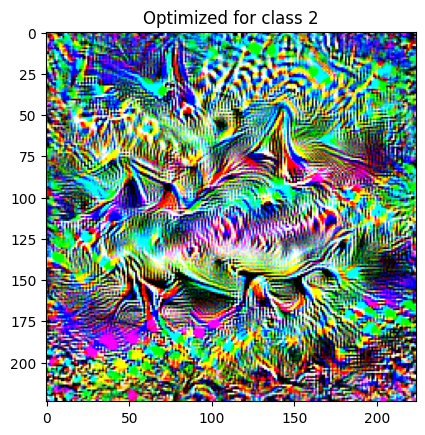

In [3]:
# Transformation Robustness

image = torch.rand((1, 3, IMG_HEIGHT, IMG_WIDTH), requires_grad = True)
optimizer = torch.optim.Adam([image], lr = LEARNING_RATE)

transforms = v2.Compose([
    v2.Pad(padding = JITTER_PX),
    v2.RandomCrop(size = (IMG_HEIGHT, IMG_WIDTH)),
    v2.RandomResizedCrop(size = (IMG_HEIGHT, IMG_WIDTH), scale = (1-SCALE_FACTOR, 1)),
    v2.RandomRotation(ROTATION_DEG)
])

for i in range(NUM_ITER):
  optimizer.zero_grad()

  transformed_image = transforms(image.clone())

  preprocessed_image = preprocess(transformed_image)

  out = model(preprocessed_image)

  loss = -out[0, TARGET_CLASS]
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    image.data.clamp_(0, 1)

  if (i + 1) % 10 == 0:
    print(f"Iteration {i + 1}/{NUM_ITER}: Loss: {loss.item()}")

final_image = image.detach().clone().squeeze(0)
plt.imshow(TF.to_pil_image(final_image))
plt.title(f"Optimized for class {TARGET_CLASS}")
plt.show()
